In [1]:
import numpy as np
import pandas as pd

# read in high and low expression one_hot files
high_exp = pd.concat(
    [pd.read_csv(f"..\josh\high_exp_one_hot_{i}.csv", index_col=0)
     for i in range(1, 5)]
)
low_exp = pd.concat(
    [pd.read_csv(f"..\josh\low_exp_one_hot_{i}.csv", index_col=0)
     for i in range(1, 5)]
)

# concatenate to form a single dataframe
data_df = pd.concat([high_exp, low_exp], axis=0)

# function to convert csv files into 
def string_to_matrix(string):
    # convert string to list of one_hot lists
    string = str(string)
    list_of_strings = string.split('], [')
    list_of_lists = [channels.strip().replace('[', '').replace(']', '').replace(',', '').split() 
                     for channels in list_of_strings
                     if 'nan' not in list_of_strings
                    ]
    # add padding
    remaining_pad = 181 - len(list_of_lists)
    while remaining_pad > 0:
        list_of_lists.append(list([0 for x in range(0, 64)]))
        remaining_pad = remaining_pad - 1
    # return padded one_hot matrix
    return np.array(list_of_lists).astype(np.float)

data_df['one_hot_matrix'] = data_df['one_hot_matrix'].apply(string_to_matrix)

In [2]:
# create train test split
from sklearn.model_selection import train_test_split

max_len = 181
width = 64

X = np.zeros((22615, max_len, width))
for idx, one_hot_matrix in enumerate(data_df['one_hot_matrix'].values):
    X[idx, :, :] = one_hot_matrix

    
y = data_df['class'].values

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [3]:
# simple model per Yoon Kim (2014)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, GlobalMaxPooling1D

model = Sequential()
model.add(Conv1D(100, 3, activation='relu', input_shape=(181, 64)))
model.add(GlobalMaxPooling1D())
# model.add(Flatten())
# model.add(Dense(32))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=50, epochs=10,
          validation_data=(x_test, y_test), verbose=2)

C:\Users\Jay\Miniconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Train on 15830 samples, validate on 6785 samples
Epoch 1/10
 - 19s - loss: 0.6994 - acc: 0.5213 - val_loss: 0.6831 - val_acc: 0.5860
Epoch 2/10
 - 19s - loss: 0.6814 - acc: 0.5566 - val_loss: 0.6744 - val_acc: 0.6180
Epoch 3/10
 - 20s - loss: 0.6681 - acc: 0.5943 - val_loss: 0.6667 - val_acc: 0.6146
Epoch 4/10
 - 20s - loss: 0.6558 - acc: 0.6138 - val_loss: 0.6612 - val_acc: 0.6118
Epoch 5/10
 - 20s - loss: 0.6456 - acc: 0.6310 - val_loss: 0.6563 - val_acc: 0.6153
Epoch 6/10
 - 20s - loss: 0.6334 - acc: 0.6437 - val_loss: 0.6520 - val_acc: 0.6197
Epoch 7/10
 - 22s - loss: 0.6231 - acc: 0.6556 - val_loss: 0.6485 - val_acc: 0.6255
Epoch 8/10
 - 24s - loss: 0.6173 - acc: 0.6604 - val_loss: 0.6470 - val_acc: 0.6255
Epoch 9/10
 - 22s - loss: 0.6042 - acc: 0.6789 - val_loss: 0.6474 - val_acc: 0.6252
Epoch 10/10
 - 22s - loss: 0.5963 - acc: 0.6833 - val_loss: 0.6442 - val_acc: 0.6256


In [4]:
#try to vizulaize the filters
weights = model.get_weights()

In [13]:
weights[0].shape

(3, 64, 100)

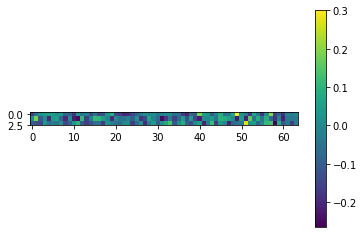

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
w = weights[0][:,:,1]
plt.imshow(w)
plt.colorbar()

In [11]:
# Now trying to use an example based on Kim's paper.
# adapted from https://github.com/alexander-rakhlin/CNN-for-Sentence-Classification-in-Keras/blob/master/sentiment_cnn.py

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, MaxPooling1D, Convolution1D, Flatten
from keras.layers.merge import Concatenate

filter_sizes = (3, 4, 5)
num_filters = 10
dropout_prob = (0.5, 0.8)
hidden_dims = 50

# prepare input shape
input_shape = (181, 64)
model_input = Input(shape=input_shape)
z = model_input

# z = Dropout(dropout_prob[0])(z)

# Convolutional ddddblock
conv_blocks = []
for sz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
# z = Flatten()(z)
z = Dropout(dropout_prob[1])(z)
# z = Dense(hidden_dims, activation="selu")(z)
model_output = Dense(1, activation="sigmoid")(z)

model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
model.fit(x_train, y_train, batch_size=50, epochs=10,
          validation_data=(x_test, y_test), verbose=2)

Train on 15830 samples, validate on 6785 samples
Epoch 1/10
 - 9s - loss: 0.7368 - acc: 0.5057 - val_loss: 0.6908 - val_acc: 0.5422
Epoch 2/10
 - 7s - loss: 0.6974 - acc: 0.5190 - val_loss: 0.6889 - val_acc: 0.5761
Epoch 3/10
 - 7s - loss: 0.6894 - acc: 0.5331 - val_loss: 0.6875 - val_acc: 0.5688
Epoch 4/10
 - 7s - loss: 0.6859 - acc: 0.5427 - val_loss: 0.6855 - val_acc: 0.5826
Epoch 5/10
 - 7s - loss: 0.6843 - acc: 0.5519 - val_loss: 0.6837 - val_acc: 0.5951
Epoch 6/10
 - 7s - loss: 0.6815 - acc: 0.5630 - val_loss: 0.6814 - val_acc: 0.6022
Epoch 7/10
 - 7s - loss: 0.6800 - acc: 0.5672 - val_loss: 0.6792 - val_acc: 0.6041
Epoch 8/10
 - 7s - loss: 0.6750 - acc: 0.5768 - val_loss: 0.6764 - val_acc: 0.6088
Epoch 9/10
 - 7s - loss: 0.6729 - acc: 0.5826 - val_loss: 0.6740 - val_acc: 0.6091
Epoch 10/10
 - 7s - loss: 0.6708 - acc: 0.5900 - val_loss: 0.6724 - val_acc: 0.6115


### the following architecture comes from the keras docs... seems to overfit

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(181, 64)))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.8))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=50, epochs=10,
          validation_data=(x_test, y_test), verbose=2)

Train on 15830 samples, validate on 6785 samples
Epoch 1/10
 - 13s - loss: 0.6888 - acc: 0.5275 - val_loss: 0.6705 - val_acc: 0.5876
Epoch 2/10
 - 12s - loss: 0.6568 - acc: 0.6089 - val_loss: 0.6462 - val_acc: 0.6318
Epoch 3/10
 - 14s - loss: 0.6470 - acc: 0.6318 - val_loss: 0.6423 - val_acc: 0.6335
Epoch 4/10
 - 13s - loss: 0.6381 - acc: 0.6372 - val_loss: 0.6391 - val_acc: 0.6321
Epoch 5/10
 - 13s - loss: 0.6274 - acc: 0.6483 - val_loss: 0.6343 - val_acc: 0.6370
Epoch 6/10
 - 14s - loss: 0.6152 - acc: 0.6653 - val_loss: 0.6348 - val_acc: 0.6327
Epoch 7/10
 - 12s - loss: 0.5949 - acc: 0.6810 - val_loss: 0.6438 - val_acc: 0.6248
Epoch 8/10
 - 13s - loss: 0.5709 - acc: 0.7025 - val_loss: 0.6346 - val_acc: 0.6323
Epoch 9/10
 - 13s - loss: 0.5453 - acc: 0.7233 - val_loss: 0.6692 - val_acc: 0.6327
Epoch 10/10
 - 12s - loss: 0.5106 - acc: 0.7488 - val_loss: 0.6699 - val_acc: 0.6246
